# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [4]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [3]:
## load dataset here
df = pd.read_csv("/content/drive/MyDrive/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [5]:
## parsing data here
images, labels = parse_data(df)


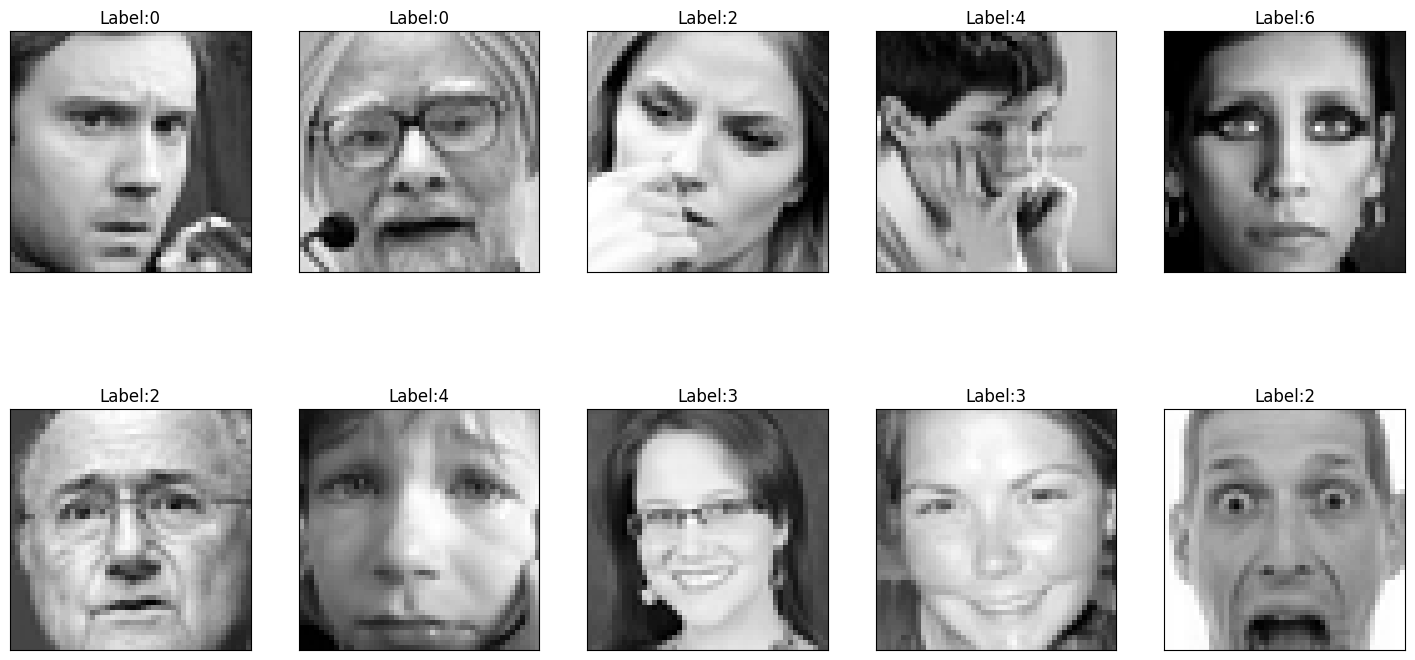

In [6]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

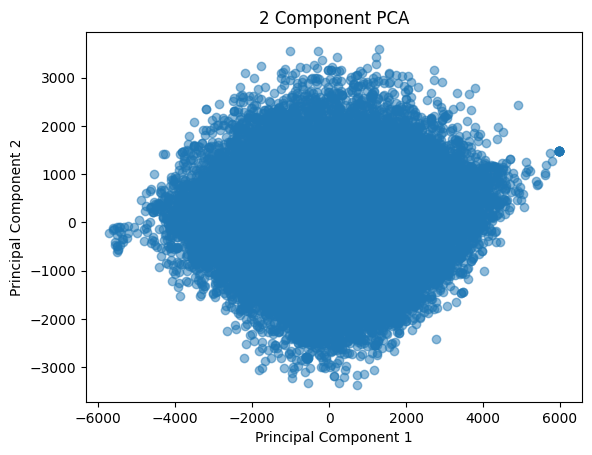

In [ ]:
from sklearn.decomposition import PCA

def plot_pca(images):
    pca = PCA(n_components=2)
    images_flat = images.reshape((images.shape[0], -1))
    images_pca = pca.fit_transform(images_flat)

    plt.scatter(images_pca[:, 0], images_pca[:, 1], alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2 Component PCA')
    plt.show()


plot_pca(images)


Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

#### Explanation:

To determine the optimal number of principal components, we follow these steps:

1. **Fit the PCA Model**: First, we fit a PCA model to the dataset. This model calculates the explained variance ratio for each principal component, indicating how much variance each component captures.

2. **Cumulative Explained Variance**: Next, we calculate the cumulative explained variance, which is the cumulative sum of the explained variance ratios. This helps us understand how much total variance is captured as we add more components.

3. **Determine Optimal Components**: We then look for the point where the cumulative explained variance reaches a significant threshold, commonly 95%. This means we choose the smallest number of components that can explain at least 95% of the total variance in the data.

   - **X-axis**: Represents the number of principal components.
   - **Y-axis**: Represents the cumulative explained variance.

In the plot below, we can see the cumulative explained variance increases rapidly at first and then starts to flatten out. This indicates that the initial components capture most of the variance, and adding more components contributes less and less additional variance.

The optimal number of components is determined by finding the point on the X-axis where the Y-axis value reaches 0.95 (or 95%). From the plot, this point appears to be around 255 components, but this exact number can be determined programmatically.

The main goal is to balance dimensionality reduction with information retention. By choosing the number of components that explain 95% of the variance, we reduce the dimensionality significantly while retaining most of the important information from the dataset. This makes subsequent machine learning tasks more efficient and manageable.



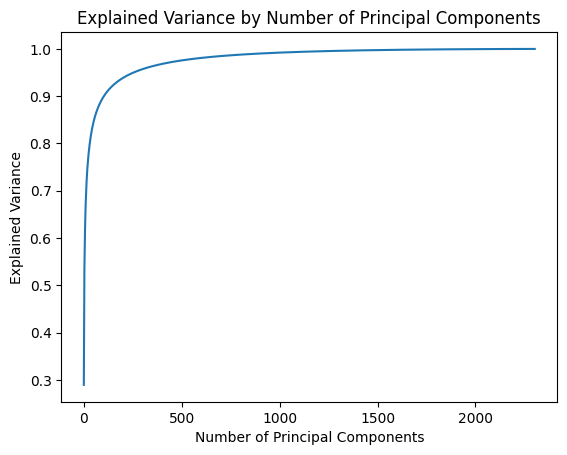

Optimal number of principal components: 255


In [ ]:
def determine_optimal_pcs(images):
    pca = PCA()
    images_flat = images.reshape((images.shape[0], -1))
    pca.fit(images_flat)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(explained_variance)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Explained Variance')
    plt.title('Explained Variance by Number of Principal Components')
    plt.show()

    optimal_pcs = np.argmax(explained_variance >= 0.95) + 1
    return optimal_pcs

optimal_pcs = determine_optimal_pcs(images)
print(f"Optimal number of principal components: {optimal_pcs}")


## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

Orginal Data

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
from skimage.transform import resize

# Function to resize images
def resize_images(images, new_size=(24, 24)):
    resized_images = np.zeros((images.shape[0], new_size[0], new_size[1]))
    for i in range(images.shape[0]):
        resized_images[i] = resize(images[i], new_size, anti_aliasing=True)
    return resized_images

# Resizing the images
X_train_resized = resize_images(X_train, new_size=(24, 24))
X_test_resized = resize_images(X_test, new_size=(24, 24))


In [ ]:

# Prepare data for CNN
X_train_cnn = X_train_resized[..., np.newaxis]
X_test_cnn = X_test_resized[..., np.newaxis]
input_shape = X_train_cnn.shape[1:]

# Define a simple CNN model for feature extraction
def build_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu')
    ])
    return model

# Build and compile the CNN model
cnn_model = build_cnn(input_shape)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Extract features using the CNN
cnn_feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-1].output)
X_train_features = cnn_feature_extractor.predict(X_train_cnn)
X_test_features = cnn_feature_extractor.predict(X_test_cnn)


225/225 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from joblib import parallel_backend

# Scale the extracted features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Define models and parameter grids
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "MLP": MLPClassifier(max_iter=1000, early_stopping=True, n_iter_no_change=10)
}

param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10]},
    "Decision Tree": {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    "Random Forest": {'n_estimators': [50, 100, 200]},
    "MLP": {'hidden_layer_sizes': [(50,), (100,), (50,50)], 'alpha': [0.0001, 0.001]}
}

# Train and evaluate models using parallel processing and grid search
for name, model in models.items():
    with parallel_backend('threading', n_jobs=-1):
        grid_search = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        print(f"{name} best params: {grid_search.best_params_}")
        print(f"{name} classification report:\n")
        print(classification_report(y_test, grid_search.predict(X_test_scaled)))


Logistic Regression best params: {'C': 0.1}
Logistic Regression classification report:

              precision    recall  f1-score   support

           0       0.32      0.13      0.19       985
           1       0.00      0.00      0.00       102
           2       0.26      0.10      0.14      1043
           3       0.37      0.69      0.48      1765
           4       0.32      0.25      0.28      1210
           5       0.38      0.39      0.39       795
           6       0.30      0.30      0.30      1278

    accuracy                           0.34      7178
   macro avg       0.28      0.27      0.25      7178
weighted avg       0.32      0.34      0.31      7178

Decision Tree best params: {'max_depth': None, 'min_samples_split': 2}
Decision Tree classification report:

              precision    recall  f1-score   support

           0       0.22      0.24      0.23       985
           1       0.23      0.25      0.24       102
           2       0.28      0.27      0.27

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Collect metrics for comparison
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

for name, model in models.items():
    with parallel_backend('threading', n_jobs=-1):
        grid_search = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)

        best_model = grid_search.best_estimator_
        y_pred = grid_search.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        metrics["Model"].append(name)
        metrics["Accuracy"].append(accuracy)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)

        print(f"{name} best params: {grid_search.best_params_}")
        print(f"{name} classification report:\n")
        print(classification_report(y_test, y_pred))

# Display collected metrics
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


Logistic Regression best params: {'C': 0.1}
Logistic Regression classification report:

              precision    recall  f1-score   support

           0       0.32      0.13      0.19       985
           1       0.00      0.00      0.00       102
           2       0.26      0.10      0.14      1043
           3       0.37      0.69      0.48      1765
           4       0.32      0.25      0.28      1210
           5       0.38      0.39      0.39       795
           6       0.30      0.30      0.30      1278

    accuracy                           0.34      7178
   macro avg       0.28      0.27      0.25      7178
weighted avg       0.32      0.34      0.31      7178

Decision Tree best params: {'max_depth': None, 'min_samples_split': 2}
Decision Tree classification report:

              precision    recall  f1-score   support

           0       0.23      0.25      0.24       985
           1       0.25      0.31      0.28       102
           2       0.28      0.28      0.28

PCA DATA


In [9]:
# Flatten the images for PCA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [12]:
# Apply PCA
pca = PCA(n_components=255)  # Example reduction to 255 components
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

In [13]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

In [14]:
# Define models and parameter grids
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "MLP": MLPClassifier(max_iter=1000, early_stopping=True, n_iter_no_change=10)
}

param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10]},
    "Decision Tree": {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    "Random Forest": {'n_estimators': [50, 100, 200]},
    "MLP": {'hidden_layer_sizes': [(50,), (100,), (50,50)], 'alpha': [0.0001, 0.001]}
}

In [19]:
# Collect metrics for comparison
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Train and evaluate models using parallel processing and grid search
for name, model in models.items():
    with parallel_backend('threading', n_jobs=-1):
        grid_search = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)

        best_model = grid_search.best_estimator_
        y_pred = grid_search.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        metrics["Model"].append(name)
        metrics["Accuracy"].append(accuracy)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)

        print(f"{name} best params: {grid_search.best_params_}")
        print(f"{name} classification report:\n")
        print(classification_report(y_test, y_pred))

# Display collected metrics
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Logistic Regression best params: {'C': 0.1}
Logistic Regression classification report:

              precision    recall  f1-score   support

           0       0.27      0.15      0.20       985
           1       0.21      0.03      0.05       102
           2       0.27      0.15      0.19      1043
           3       0.43      0.68      0.53      1765
           4       0.29      0.30      0.29      1210
           5       0.46      0.46      0.46       795
           6       0.37      0.34      0.35      1278

    accuracy                           0.37      7178
   macro avg       0.33      0.30      0.30      7178
weighted avg       0.35      0.37      0.35      7178

Decision Tree best params: {'max_depth': 10, 'min_samples_split': 2}
Decision Tree classification report:

              precision    recall  f1-score   support

           0       0.20      0.11      0.14       985
           1       0.36      0.05      0.09       102
           2       0.24      0.16      0.19  

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [21]:
# Compare performance and identify best model
best_model_index = metrics_df["Accuracy"].idxmax()
best_model_name = metrics_df.loc[best_model_index, "Model"]
best_model_metrics = metrics_df.loc[best_model_index]

print(f"\nBest model: {best_model_name}")
print(f"Accuracy: {best_model_metrics['Accuracy']}")
print(f"Precision: {best_model_metrics['Precision']}")
print(f"Recall: {best_model_metrics['Recall']}")
print(f"F1-Score: {best_model_metrics['F1-Score']}")



Best model: Random Forest
Accuracy: 0.40261911395932015
Precision: 0.4835160087334441
Recall: 0.40261911395932015
F1-Score: 0.3708995607033573


In [23]:
# Identify the emotion category where the model makes the most accurate and most errors
confusion = confusion_matrix(y_test, grid_search.predict(X_test_scaled))
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

true_positives = np.diag(confusion)
most_accurate_emotion = emotion_labels[np.argmax(true_positives)]
most_errors_emotion = emotion_labels[np.argmax(confusion.sum(axis=1) - true_positives)]

print(f"Emotion with the most accurate predictions: {most_accurate_emotion}")
print(f"Emotion with the most errors: {most_errors_emotion}")

Emotion with the most accurate predictions: Happy
Emotion with the most errors: Neutral


## Model Performance Comparison

**Model Performance Comparison:**
1. **Accuracy**: Accuracy measures the proportion of correctly predicted instances out of the total instances. In this case, the Random Forest model has an accuracy of 0.4026, meaning it correctly predicts about 40.26% of the instances.
2. **Precision**: Precision is the ratio of correctly predicted positive observations to the total predicted positives. A precision of 0.4835 indicates that out of all the instances predicted as a certain emotion, 48.35% were correct.
3. **Recall**: Recall is the ratio of correctly predicted positive observations to all the observations in the actual class. A recall of 0.4026 suggests that the model correctly identifies 40.26% of the actual instances of each emotion.
4. **F1-Score**: The F1-score is the harmonic mean of precision and recall. An F1-score of 0.3709 reflects the balance between precision and recall, considering both false positives and false negatives.

**Best Model: Random Forest**
- **Why it Performs Best**: The Random Forest model has the highest accuracy among the compared models. Despite the relatively low precision and recall, its overall performance in correctly predicting the instances outperforms other models. Random Forest is effective because it combines multiple decision trees to reduce overfitting and improve generalization.

**Emotion Category Performance**:
- **Most Accurate Predictions**: The Random Forest model makes the most accurate predictions for the emotion category 'Happy' where it has the highest true positive rate.
- **Most Errors**: The model makes the most errors in the emotion category 'Neutral' where it has the highest number of false negatives and false positives.

In summary, while the Random Forest model shows a moderate performance with an accuracy of 40.26%, it is considered the best among the evaluated models due to its relatively higher accuracy and balanced precision and recall. The detailed analysis of the confusion matrix would provide further insights into specific emotions where the model excels or struggles the most.
